# 検定のためのサンプルサイズの決め方

## シンプルなやつ（母比率の検定の場合）

統計学の入門書にあるようなシンプルなやつ

母比率$p$の95%信頼区間は、標本比率$\hat{p}$を用いて

$$
\widehat{p}-1.96 \times \sqrt{\frac{\widehat{p}(1-\widehat{p})}{n}} \leq p \leq \widehat{p}+1.96 \times \sqrt{\frac{\widehat{p}(1-\widehat{p})}{n}}
$$

と求めることができる

区間の幅部分が両側合計で$w$以下にしたい場合は

$$
2 \times 1.96 \times \sqrt{\frac{\widehat{p}(1-\widehat{p})}{n}} \leq w
$$

を解けばよいので


$$
\sqrt{n} \geq 2 \times 1.96 \times \sqrt{\widehat{p}(1-\widehat{p})} \times \frac{1}{w}
$$



$$
n \geq (2 \times 1.96 \times \sqrt{\widehat{p}(1-\widehat{p})} \times \frac{1}{w})^2
$$


となる

例えば、事前調査により$\hat{p} = 0.1$であることがわかっていて、幅$w=0.01$で95%信頼区間を求めたい場合は

In [1]:
from math import sqrt

w = 0.01
p_hat = 0.1

n = int( (2 * 1.96 * sqrt(p_hat * (1 - p_hat)) / w) ** 2 )
print(f"{n=}")

n=13829


In [2]:
# 信頼区間の計算
from scipy.stats import norm, sem

mu = p_hat
lower, upper = norm.interval(confidence=0.95, loc=mu, scale=sqrt((p_hat * (1 - p_hat)) / n))
width = (mu - lower) + (upper - mu)
print(f"[{lower:.3g}, {upper:.3g}], width={width:.1g}")

[0.095, 0.105], width=0.01


In [3]:
# 乱数生成してシミュレーション
import numpy as np
np.random.seed(0)
x = np.random.binomial(n=1, p=p_hat, size=int(n))

from scipy.stats import norm, sem
lower, upper = norm.interval(confidence=0.95, loc=x.mean(), scale=sem(x))
width = (x.mean() - lower) + (upper - x.mean())
print(f"[{lower:.3g}, {upper:.3g}], width={width:.1g}")

[0.0937, 0.104], width=0.01


### statsmodels

[samplesize_confint_proportion](https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.samplesize_confint_proportion.html#statsmodels.stats.proportion.samplesize_confint_proportion)
を使うことで、想定される比率、幅、有意水準からサンプル数を推定できる


In [7]:
from statsmodels.stats.proportion import samplesize_confint_proportion

n = samplesize_confint_proportion(proportion=0.1, half_length=0.01, alpha=0.05, method='normal')
print(f"{n:,.0f}")

3,457


## 本格的な実験手順


:::{admonition} サンプルサイズの4大因子

次の4つのうち3つが決まれば残る1つも決まる

1. サンプルサイズ（Sample size）
2. 効果量（Effect size）
    - 比較対象（平均や割合など）の差の大きさ。
    - 例：Cohen's d, r, η² など
3. 有意水準（Significance level, $\alpha$）
    - 第1種の過誤（誤って帰無仮説を棄却する）の確率
4. 検出力（Power, $1-\beta$）
    - 帰無仮説が誤っているときに、それを正しく棄却できる確率。第2種の過誤（棄却できない確率$\beta$）をしない確率
    - 通常は 0.8（80%）以上が望ましいとされる

→ サンプルサイズを設計するにはサンプルサイズ以外の3つを設定すればいい

→ 検出力を推定するには検出力以外の3つを使えばいい

:::

### 手順1. 事前分析：サンプルサイズの設計

調査（A/Bテストなど）を行う前のサンプルサイズ設計。

1. 効果量
2. 有意水準
3. 検出力

を決めてサンプルサイズを算出する。

有意水準は5%、検出力は80%などにすればいいが、効果量がちょっと難しい。

A/Bテストでいうと「この新施策で成約率が5ポイント上昇するはず」などの仮定をおいて効果量を算出することになる。

#### 効果量

代表的な効果量にはCohenのdやhがある。

| 効果量      | 用途            | 備考                                  |
| ----------- | --------------- | ------------------------------------- |
| Cohen's $d$ | 2群の平均値の差 | 目安：0.2=小, 0.5=中, 0.8=大          |
| Hedges' $g$ | 2群の平均値の差 | Cohen's $d$の小標本でのバイアス補正版 |
| Cohen's $h$ | 2群の比率の差   | 目安：0.2=小, 0.5=中, 0.8=大          |




:::{admonition} Cohen's $d$

2群の平均値の差の効果量。

$$
d=\frac{\bar{X}_1-\bar{X}_2}{s_{\text {pooled }}}
$$


ここで：
- $\bar{X}_1$ ：群1の平均
- $\bar{X}_2$ ：群2の平均
- $s_{\text {pooled }}$ ：プールされた標準偏差（両群の分散を平均したもの）

$$
s_{\text {pooled }}=\sqrt{\frac{\left(n_1-1\right) s_1^2+\left(n_2-1\right) s_2^2}{n_1+n_2-2}}
$$

- $s_1^2, s_2^2:$ それぞれの群の不偏分散
- $n_1, n_2$ ：それぞれの群のサンプルサイズ

:::



In [54]:
import numpy as np

def cohens_d(x1: np.array, x2: np.array) -> float:
    n1, n2 = len(x1), len(x2)
    denom = (n1 - 1) * x1.std()**2 + (n2 - 1) * x2.std()**2
    num = n1 + n2 - 2
    pooled_std = np.sqrt(denom / num)
    return (x1.mean() - x2.mean()) / pooled_std

In [71]:
np.random.seed(0)

d = cohens_d(
    x1 = np.random.normal(loc=0, scale=1, size=450),
    x2 = np.random.normal(loc=0, scale=1, size=300),
)
print(f"{d=:.3f}")


d = cohens_d(
    x1 = np.random.normal(loc=0.5, scale=1, size=350),
    x2 = np.random.normal(loc=0, scale=1, size=300),
)
print(f"{d=:.3f}")

d=0.103
d=0.485


:::{admonition} Hdges' $g$

Cohen's $d$はサンプルサイズが小さいときに過大評価するバイアスがあるため補正する係数を乗じたもの

$$
g=J \cdot d
$$


ここで：

- $d$ ：Cohen's $d$ （2群の標準化された平均差）
- $J:$ バイアス補正係数（通常は小さくなる）

$$
J=1-\frac{3}{4 (n_1+n_2 - 2)-1}
$$

:::



In [101]:
def hedges_g(x1: np.array, x2: np.array) -> float:
    d = cohens_d(x1, x2)
    n1, n2 = len(x1), len(x2)
    J = 1 - (3 / (4 * (n1 + n2 - 2) - 1))
    return J * d

In [120]:
np.random.seed(0)

x1 = np.random.normal(loc=0, scale=2, size=150)
x2 = np.random.normal(loc=0, scale=1, size=100)

d = cohens_d(x1, x2)
print(f"{d=:.3f}")
J = 1 - (3 / (4 * (x1.size + x2.size - 2) - 1))
print(f"{J=:.3f}")
g = hedges_g(x1, x2)
print(f"{g=:.3f}")

d=0.213
J=0.997
g=0.212



:::{admonition} Cohen's $h$

2群の比率の差の効果量。

$$
h=2 \cdot \arcsin (\sqrt{p_1})-2 \cdot \arcsin (\sqrt{p_2})
$$

ここで：
- $p_1$ ：群1の比率（成約率など）
- $p_2$ ：群2の比率（成約率など）

:::


In [104]:
import math

def cohens_h(p1, p2):
    return 2 * (math.asin(p1**0.5) - math.asin(p2**0.5))

h = cohens_h(0.15, 0.10)
print(f"{h=:.3f}")

h=0.152


### 手順2. 事後分析：検出力分析

1. 実測のサンプルサイズ
2. 実測の効果量
3. 有意水準

で検出力を算出する

In [110]:
# 平均値の差の場合 ------------------------------
# サンプルの例
import numpy as np
np.random.seed(0)
x1 = np.random.normal(loc=0.2, scale=2, size=150)
x2 = np.random.normal(loc=0, scale=1, size=100)

# calc power
from statsmodels.stats.power import TTestIndPower
power_analysis = TTestIndPower()
power = power_analysis.power(
    nobs1=x1.size,
    ratio=x2.size / x1.size,  # nobs2 = nobs1 * ratio
    effect_size=hedges_g(x1, x2),
    alpha=0.05,
)
print(f"{power=:.3f}")

power=0.721


In [131]:
# 比率の差の場合 ------------------------------
# サンプルの例
import numpy as np
np.random.seed(0)
x1 = np.random.binomial(n=1, p=0.10, size=750)
x2 = np.random.binomial(n=1, p=0.15, size=600)

# calc power
from statsmodels.stats.power import NormalIndPower
power_analysis = NormalIndPower()
power = power_analysis.power(
    nobs1=x1.size,
    ratio=x2.size / x1.size,  # nobs2 = nobs1 * ratio
    effect_size=hedges_g(x1, x2),
    alpha=0.05,
)
print(f"{power=:.3f}")

power=0.954


### statsmodels

statsmodels: [Size Calculations](https://www.statsmodels.org/dev/stats.html#power-and-sample-size-calculations)

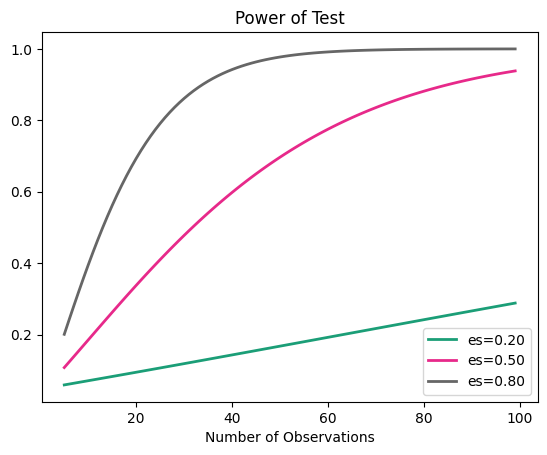

In [106]:
# サンプルサイズの変化に応じた検定力の推移
import numpy as np
from statsmodels.stats.power import TTestIndPower

power_analysis = TTestIndPower()
fig = power_analysis.plot_power(
    dep_var='nobs',
    nobs=np.arange(5, 100),
    effect_size=[0.2, 0.5, 0.8],
    alpha=0.05,
)

statsmodelsの `solve_power` では、4要因のうち `None` にした要素を推定できる

In [123]:
# effect_sizeをNoneにしてeffect_sizeを推定
from statsmodels.stats.power import TTestIndPower
power_analysis = TTestIndPower()
effect_size = power_analysis.solve_power(
    nobs1=100,
    ratio=1.0,  # nobs2 = nobs1 * ratio
    effect_size=None,
    alpha=0.05,
    power=0.80,
)
print(f"{effect_size=:.3f}")

effect_size=0.398


In [129]:
# effect_sizeをNoneにして必要なeffect_sizeを推定
from statsmodels.stats.power import NormalIndPower
power_analysis = NormalIndPower()
effect_size = power_analysis.solve_power(
    nobs1=1000,
    ratio=1.0,  # nobs2 = nobs1 * ratio
    effect_size=None,
    alpha=0.05,
    power=0.80,
)
print(f"{effect_size=:.3f}")

effect_size=0.125


## 参考

- [21-4. 必要なサンプルサイズ1 | 統計学の時間 | 統計WEB](https://bellcurve.jp/statistics/course/9129.html?srsltid=AfmBOor_VrX0VRNoaDn20rzg-4p3TdUMNflYCO7EGUwvrOtqo6LQ94bw)
- [31-6. サンプルサイズの設計と検出力分析 | 統計学の時間 | 統計WEB](https://bellcurve.jp/statistics/course/12769.html)
- [Python初心者の備忘録 #14 \~統計学入門編04\~ #Python3 - Qiita](https://qiita.com/Yushin-Tati/items/8aeb2c190e3494dd6b78#%E3%81%AF%E3%81%98%E3%82%81%E3%81%AB)
- [Wang, H., & Chow, S. C. (2014). Sample Size Calculation for Comparing Variabilities. Wiley StatsRef: Statistics Reference Online. John Wiley & Sons, Ltd.](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=77a4e5a32157ddd2c8ccab43093e7a7602e6938f)
    - ちゃんとやる場合にはこれ参考になりそう
- [サンプルサイズの決め方 (統計ライブラリー) | 永田 靖 |本 | 通販 | Amazon](https://www.amazon.co.jp/dp/4254126654)
